# 뉴스 데이터

In [63]:
import pandas as pd

news_df = pd.read_csv("data/Apple_news.csv")

news_df['Date'] = pd.to_datetime(news_df['pubDate']).dt.date

In [64]:
news_df.head()

,id,title,summary,link,publisher,category,pubDate,image,related,source,collection_period,Date
0,135270013,3 No-Brainer Artificial Intelligence (AI) Grow...,Finding value in artificial intelligence (AI) ...,https://finnhub.io/api/news?id=3e8de88fcb69df9...,NaN,company,2025-06-14 09:55:00,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,2025-06-07_2025-06-14,2025-06-14
1,135258199,Apple Reroutes 97% Of Foxconn iPhone Exports F...,Apple Inc. (NASDAQ:AAPL) has reportedly increa...,https://finnhub.io/api/news?id=e6e09272a3b910a...,NaN,company,2025-06-14 01:30:33,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,2025-06-07_2025-06-14,2025-06-14
2,135270015,Why Superintelligent AI Isn’t Taking Over Anyt...,"Despite claims from top names in AI, researche...",https://finnhub.io/api/news?id=d8a8fdff582d1f1...,NaN,company,2025-06-14 01:00:00,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,2025-06-07_2025-06-14,2025-06-14
3,135257945,Why Apple (AAPL) Dipped More Than Broader Mark...,Apple (AAPL) reached $196.45 at the closing of...,https://finnhub.io/api/news?id=6964bc22b1f8f8c...,NaN,company,2025-06-13 21:45:02,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,2025-06-07_2025-06-14,2025-06-13
4,135257921,Apple's $4.4B India Play: The Secret iPhone Sh...,"As Trump targets China, Apple quietly reroutes...",https://finnhub.io/api/news?id=7f50a3430d3f330...,NaN,company,2025-06-13 21:06:46,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,2025-06-07_2025-06-14,2025-06-13


# 주식 데이터

In [65]:
import yfinance as yf

def fetch_stock_data(period: str = '1y', interval: str = '1d') -> pd.DataFrame:
    """
    AAPL 1년치 일별 가격을 가져와
      1) MultiIndex 헤더 평탄화
      2) Date를 컬럼으로 올리고
      3) 컬럼명을 통일(Adj Close → Adj_Close)
      4) Close 기준 일일 수익률 계산
    해서 반환합니다.
    """
    # 1) yfinance 로드
    df = yf.download(
        tickers='AAPL',
        period=period,
        interval=interval,
        progress=False,
        auto_adjust=False
    )
    if df.empty:
        return df

    # 2) MultiIndex 평탄화
    # 컬럼이 튜플이면 tuple[0]만, 아니면 원래 컬럼명 그대로 사용
    new_cols = []
    for col in df.columns:
        if isinstance(col, tuple):
            new_cols.append(col[0])
        else:
            new_cols.append(col)
    df.columns = new_cols

    # 3) 인덱스를 컬럼으로
    df = df.reset_index()

    # 4) 컬럼명 통일
    df.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)

    # 5) 일일 수익률 계산 (Close 기준)
    df['return'] = df['Close'].pct_change()

    # 6) 필요한 컬럼만 뽑아서 반환
    cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', 'return']
    return df[[c for c in cols if c in df.columns]]

# 실행 예시
stock_df = fetch_stock_data()
print(stock_df.columns.tolist())
display(stock_df.head())

['Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', 'return']


,Date,Open,High,Low,Close,Adj_Close,Volume,return
0,2024-06-18,217.589996,218.630005,213.000000,214.289993,213.292480,79943300,NaN
1,2024-06-20,213.929993,214.240005,208.850006,209.679993,208.703934,86172500,-0.021513
2,2024-06-21,210.389999,211.889999,207.110001,207.490005,206.524170,246421400,-0.010444
3,2024-06-24,207.720001,212.699997,206.589996,208.139999,207.171127,80727000,0.003133
4,2024-06-25,209.149994,211.380005,208.610001,209.070007,208.096802,56713900,0.004468


# SNS 데이터

In [66]:
sns_df = pd.read_csv("data/user_@tim_cook_tweets.csv")

sns_df["Date"] = pd.to_datetime(sns_df.pop("created_at")).dt.date

/var/folders/s8/66p4h7k57l5cwgl_zy6_z2nw0000gn/T/ipykernel_58666/1432506669.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sns_df["Date"] = pd.to_datetime(sns_df.pop("created_at")).dt.date


# 전처리

In [67]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# 필요한 NLTK 데이터 다운로드 (최초 1회만)
nltk.download('stopwords')
nltk.download('wordnet')

# 불용어와 표제어 도구 초기화
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text: str) -> str:
    """
    1) 소문자화  
    2) URL, HTML 태그 제거  
    3) 영숫자 및 공백 문자만 남기기  
    4) 토큰화 → 불용어 제거 → 표제어 처리 → 다시 결합  
    """
    if not isinstance(text, str):
        return ""
    # 1. 소문자
    text = text.lower()
    # 2. URL 제거
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # 3. HTML 태그 제거
    text = re.sub(r'<.*?>', '', text)
    # 4. 특수문자 제거 (영숫자, 공백만)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # 5. 토큰화
    tokens = text.split()
    # 6. 불용어 제거 & 표제어 처리
    tokens = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if tok not in stop_words and len(tok) > 1
    ]
    # 7. 다시 문자열로
    return ' '.join(tokens)

# NaN → 빈 문자열로 채우고 전처리 적용
for col in ['title', 'summary']:
    news_df[col] = (
        news_df[col]
        .fillna('')
        .apply(clean_text)
    )

sns_df["full_text"].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yeonseongmo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yeonseongmo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0                       today apple f1themovie severance
1      wishing incredible dad apple around world happ...
2      hard believe 20 year since steve told stanford...
3      experience new f1movie trailer iphone way appl...
4      thank developer around world joined u person v...
                             ...                        
833    audacity believe people everywhere three meal ...
834    amazing welcome back ireland thank hozier shar...
835    add every ambitious dreamer every daring creat...
836    glad support essential work friend dstnhome pa...
837    countless way make difference jaz story great ...
Name: full_text, Length: 838, dtype: object

# 뉴스 감정 분석(FinBert)

In [68]:
from transformers import pipeline
from tqdm import tqdm

# ProsusAI/finbert 모델을 활용한 sentiment-analysis pipeline
finbert_clf = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert",
    tokenizer="ProsusAI/finbert",
    return_all_scores=False,      # 가장 높은 점수의 라벨만 리턴
    device=-1                     # CPU만 사용 시 -1, GPU 사용 시 GPU 번호(예: 0)
)

# summary 리스트로 추출
texts = news_df["title"].fillna("").tolist()

# batch_size 설정 (메모리 상황에 맞춰 8~32 정도로 조절)
batch_size = 16

results = []
for i in tqdm(range(0, len(texts), batch_size), desc="FinBERT Sentiment"):
    batch = texts[i : i + batch_size]
    batch_out = finbert_clf(batch, truncation=True, batch_size=batch_size)
    results.extend(batch_out)

# 4) 결과 분리
labels = [r["label"] for r in results]
scores = [r["score"] for r in results]

# 5) news_df 에 컬럼 추가
news_df["finbert_label"] = labels
news_df["finbert_score"] = scores

# 6) 확인
print(news_df[["title","finbert_label","finbert_score"]].head())

Device set to use cpu
/Users/yeonseongmo/.pyenv/versions/3.10.13/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
FinBERT Sentiment: 100%|██████████| 549/549 [00:42<00:00, 12.77it/s]

                                               title finbert_label  \
0  brainer artificial intelligence ai growth stoc...       neutral   
1  apple reroutes 97 foxconn iphone export india ...      negative   
2            superintelligent ai taking anytime soon       neutral   
3             apple aapl dipped broader market today      positive   
4  apple 4b india play secret iphone shift reshap...      positive   

   finbert_score  
0       0.903982  
1       0.712531  
2       0.657275  
3       0.603233  
4       0.735501  


# SNS 감정분석(VADER)

In [69]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# 2) VADER 사전 다운로드 (한 번만)
nltk.download('vader_lexicon')

# 3) CSV 불러오기
#    — 경로와 파일명, 인코딩을 실제 환경에 맞춰 조정하세요.


# 4) SentimentIntensityAnalyzer 초기화
sia = SentimentIntensityAnalyzer()

# 5) full_text 컬럼에 대해 polarity_scores 적용
#    — 결과는 dict 형태로 나오므로, 별도 컬럼으로 분리해 줍니다.
sns_df["sentiment_scores"] = sns_df["full_text"].apply(lambda txt: sia.polarity_scores(str(txt)))

# 6) scores 컬럼을 DataFrame으로 풀어서 병합
scores_sns_df = sns_df["sentiment_scores"].apply(pd.Series)
sns_df = pd.concat([sns_df.drop(columns="sentiment_scores"), scores_sns_df], axis=1)

# 7) compound 값을 기준으로 간단히 라벨링 (선택)
def label_sentiment(comp):
    if comp >=  0.05: return "positive"
    if comp <= -0.05: return "negative"
    return "neutral"

sns_df["sentiment_label"] = sns_df["compound"].apply(label_sentiment)

# 8) 결과 확인
print(sns_df.head())
# 필요하다면 sns_df.to_csv(...) 로 저장하거나 이후 분석에 바로 사용하세요.

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yeonseongmo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                           full_text        Date    neg  \
0  Today at Apple. #F1TheMovie #Severance https:/...  2025-06-16  0.000   
1  Wishing all the incredible dads at Apple and a...  2025-06-15  0.000   
2  It’s hard to believe it’s been 20 years since ...  2025-06-12  0.067   
3  Experience the new @F1Movie trailer on iPhone ...  2025-06-11  0.000   
4  Thank you to all of the developers from around...  2025-06-10  0.000   

     neu    pos  compound sentiment_label  
0  1.000  0.000    0.0000         neutral  
1  0.678  0.322    0.7339        positive  
2  0.722  0.211    0.8225        positive  
3  1.000  0.000    0.0000         neutral  
4  0.878  0.122    0.4199        positive  


# 랜덤포레스트 예측

In [97]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# 0) 공통 함수 정의
def aggregate_sent(df, prefix):
    agg = df.groupby("Date").agg(
        **{f"{prefix}_avg":    ("sent_value", "mean")},
        **{f"{prefix}_count":  ("sent_value", "count")},
        **{f"{prefix}_pos_cnt":("sent_value", lambda x: (x==1).sum())},
        **{f"{prefix}_neg_cnt":("sent_value", lambda x: (x==-1).sum())},
        **{f"{prefix}_neu_cnt":("sent_value", lambda x: (x==0).sum())},
    ).reset_index()
    agg[f"{prefix}_pos_ratio"] = agg[f"{prefix}_pos_cnt"] / agg[f"{prefix}_count"]
    agg[f"{prefix}_neg_ratio"] = agg[f"{prefix}_neg_cnt"] / agg[f"{prefix}_count"]
    return agg

def make_label(r, th=0.005):
    if   r >=  th: return "up"
    elif r <= -th: return "down"
    else:           return "hold"

# 1) 레이블 → 수치 매핑
mapping = {"positive": 1, "neutral": 0, "negative": -1}
news_df["sent_value"] = news_df["finbert_label"].map(mapping)
sns_df ["sent_value"] = sns_df ["sentiment_label"].map(mapping)

# 2) 일별 감정 집계 & 시차 처리
news_daily = aggregate_sent(news_df, "news").sort_values("Date")
sns_daily  = aggregate_sent(sns_df,  "sns").sort_values("Date")

# 하루 lag (오늘 감정이 내일 예측에 쓰이지 않도록)
for col in news_daily.columns:
    if col.startswith("news_"):
        news_daily[col] = news_daily[col].shift(1)
for col in sns_daily.columns:
    if col.startswith("sns_"):
        sns_daily[col] = sns_daily[col].shift(1)

# 3) 주가 수익률 계산
stock_df = stock_df.sort_values("Date").copy()
stock_df["prev_return"]   = stock_df["Close"].pct_change()
stock_df["future_return"] = stock_df["Close"].pct_change().shift(-1)
stock_df["label"]         = stock_df["future_return"].apply(make_label)

# 4) Date 타입 통일 & 병합
stock_df["Date"]   = pd.to_datetime(stock_df["Date"])
news_daily["Date"] = pd.to_datetime(news_daily["Date"])
sns_daily["Date"]  = pd.to_datetime(sns_daily["Date"])

df = (
    stock_df
    .merge(news_daily, on="Date", how="left")
    .merge(sns_daily,  on="Date", how="left")
)

# 5) 결측치 처리: 감정 피처는 forward-fill, 나머지는 0
sent_cols = [c for c in df.columns if c.startswith("news_") or c.startswith("sns_")]
df[sent_cols] = df[sent_cols].fillna(method='ffill').fillna(0)
df.fillna(0, inplace=True)

# 6) 피처·타깃 정의
feature_cols = [
    "news_avg", "news_count", "news_pos_ratio", "news_neg_ratio",
    "sns_avg",  "sns_count",  "sns_pos_ratio",  "sns_neg_ratio",
    "prev_return"
]
X = df[feature_cols]
y = df["label"]

# 7) 학습/검증 분할 (시계열)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    shuffle=False,
    random_state=42
)

# 8) 스케일링 (선택)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# 9) 모델 학습 & 예측
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# 10) 평가
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        down       0.38      0.19      0.25        27
        hold       0.38      0.60      0.46        20
          up       0.32      0.35      0.33        26

    accuracy                           0.36        73
   macro avg       0.36      0.38      0.35        73
weighted avg       0.36      0.36      0.34        73



/var/folders/s8/66p4h7k57l5cwgl_zy6_z2nw0000gn/T/ipykernel_58666/3058544171.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[sent_cols] = df[sent_cols].fillna(method='ffill').fillna(0)


# 랜덤포레스트 예측 (감정분석 vs. 일반 주식 지표 vs. 결합)

In [98]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit


# ————————————— 1) Merge: 감정 집계 합치기 ————————————— #
df = (
    stock_df
    .merge(news_daily, on="Date", how="left")
    .merge(sns_daily,  on="Date", how="left")
)
df.fillna(0, inplace=True)  # 결측치는 0으로

# ————————————— 2) 기술 지표 추가 ————————————— #
df = df.sort_values("Date").copy()
df['MA5']           = df['Close'].rolling(5).mean().shift(1)
df['MA10']          = df['Close'].rolling(10).mean().shift(1)
df['high_low_ratio']= ((df['High'] - df['Low']) / df['Low']).shift(1)
df['vol_ratio']     = (df['Volume'] / df['Volume'].rolling(5).mean()).shift(1)

# dropna: 필수 컬럼(감정 피처 + 기술 지표 + prev_return + label) 없는 행 제거
required = [
    'news_avg','news_pos_ratio','news_neg_ratio',
    'sns_avg','sns_pos_ratio','sns_neg_ratio',
    'prev_return','label','MA5','MA10','high_low_ratio','vol_ratio'
]
df.dropna(subset=required, inplace=True)

# ————————————— 3) 피처·타깃 정의 ————————————— #
sent_feats = [
    'news_avg','news_pos_ratio','news_neg_ratio',
    'sns_avg','sns_pos_ratio','sns_neg_ratio',
    'prev_return'
]
tech_feats = [
    'prev_return','MA5','MA10','high_low_ratio','vol_ratio'
]
both_feats = sent_feats + [c for c in tech_feats if c not in sent_feats]

X_sent = df[sent_feats]
X_tech = df[tech_feats]
X_both = df[both_feats]
y       = df['label']

# ————————————— 4) 시계열 분할 & CV 함수 ————————————— #
tscv = TimeSeriesSplit(n_splits=5)
def cv_scores(X, y):
    out = []
    for tr, te in tscv.split(X):
        m = RandomForestClassifier(n_estimators=200, random_state=42)
        m.fit(X.iloc[tr], y.iloc[tr])
        preds = m.predict(X.iloc[te])
        out.append(f1_score(y.iloc[te], preds, average='weighted'))
    return np.array(out)

# ————————————— 5) 교차검증 실행 & 결과 정리 ————————————— #
scores_sent = cv_scores(X_sent, y)
scores_tech = cv_scores(X_tech, y)
scores_both = cv_scores(X_both, y)

results = pd.DataFrame({
    'Sentiment only': scores_sent,
    'Technical only': scores_tech,
    'Sentiment + Tech': scores_both
})
results.loc['mean'] = results.mean()

print(results)

      Sentiment only  Technical only  Sentiment + Tech
0           0.390408        0.259759          0.269599
1           0.342594        0.430882          0.490622
2           0.386959        0.284985          0.337575
3           0.213650        0.395660          0.356987
4           0.283806        0.120614          0.132675
mean        0.323483        0.298380          0.317492


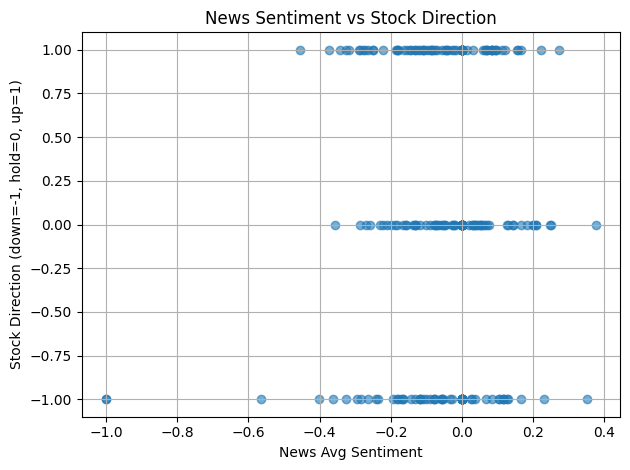

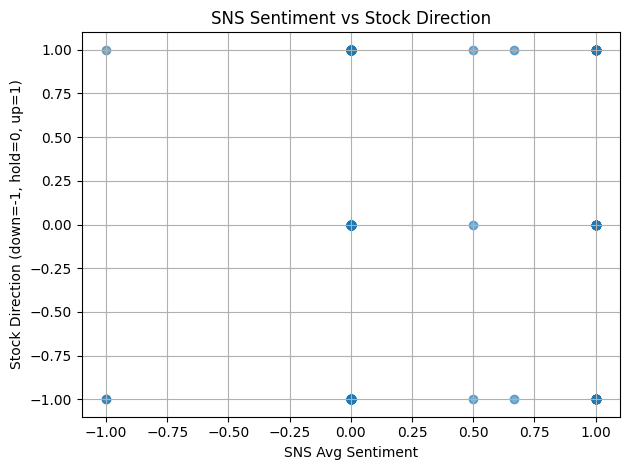

In [99]:
import matplotlib.pyplot as plt

label_map = {'down': -1, 'hold': 0, 'up': 1}
df['label_num'] = df['label'].map(label_map)

plt.figure()
plt.scatter(df['news_avg'], df['label_num'], alpha=0.6)
plt.xlabel('News Avg Sentiment')
plt.ylabel('Stock Direction (down=-1, hold=0, up=1)')
plt.title('News Sentiment vs Stock Direction')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(df['sns_avg'], df['label_num'], alpha=0.6)
plt.xlabel('SNS Avg Sentiment')
plt.ylabel('Stock Direction (down=-1, hold=0, up=1)')
plt.title('SNS Sentiment vs Stock Direction')
plt.grid(True)
plt.tight_layout()
plt.show()

 ### 이 산점도는 “뉴스 감정 점수가 높으면 주가가 오를 것이다” 혹은 “감정이 낮으면 주가가 내릴 것이다”와 같은 단순한 선형 상관관계가 존재하지 않는다는 사실을 시각적으로 확인

----------------------------------------------------------

## 1. 실험 개요
- SNS 및 뉴스의 감정분석 결과만을 사용하여 주가 방향(상승·하락·유지)을 예측

## 2. 결과 요약
- 모델의 평균 정확도는 약 30%로, 무작위 추측 수준(약 33%)과 유사  
- 감정 피처만 사용한 경우, 완전한 랜덤보다는 미미하게 높은 예측력 관찰

## 3. 해석 및 시사점
- 감정분석 지표만으로는 주가 변동을 설명하기에 충분한 정보가 부족  
- “SNS·뉴스 감정”이 단독으로 유의미한 예측 신호를 제공하지 못함

## 4. 제한점 및 후속 연구 제언
1. **데이터 규모**  
   - 거래일 기준 수백 건에 불과하여 일반화 패턴 학습에 부족  
2. **피처 다양성**  
   - 기술적 지표, 거래량 등 다른 요인을 고려하지 않아 상호작용 효과 미반영  
3. **감정 분석 품질**  
   - FinBERT/VADER 단일 모델의 한계로, 보다 정교한 분류·주제 분류 기법 필요  

## 5. 결론 및 향후 과제
- 현 데이터·방법론만으로는 “SNS·뉴스 감정”이 주가 예측의 유의미한 단독 신호라고 단정하기 어려움  
- 그러나 **데이터·방법론적 제약**으로 인한 결과일 가능성이 크므로,  
  - 더 큰 규모의 시계열 데이터 확보  
  - 추가 피처(기술 지표 등) 도입  
  - 다양한 모델·파라미터 실험을 통한 재검증 필요  